# Classification

In [1]:
import numpy as np
import os
import io
import warnings

In [7]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, precision_score, recall_score, classification_report, make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import ssl
import urllib.request

ssl._create_default_https_context = ssl._create_unverified_context

urllib.request.install_opener(
    urllib.request.build_opener(
        urllib.request.HTTPSHandler(context=ssl._create_default_https_context())
    )
)

X, y = fetch_openml('mnist_784', version=1, as_frame=True, return_X_y=True)

print(X.shape, y.shape)

(70000, 784) (70000,)


In [6]:
X = X.to_numpy()
y = y.to_numpy()

In [9]:
target_names = np.unique(y)
print(target_names)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [10]:
X = MinMaxScaler().fit_transform(X)
print("Minimum:{0}, Maximum:{1}".format(np.min(X),np.max(X)))

Minimum:0.0, Maximum:1.0


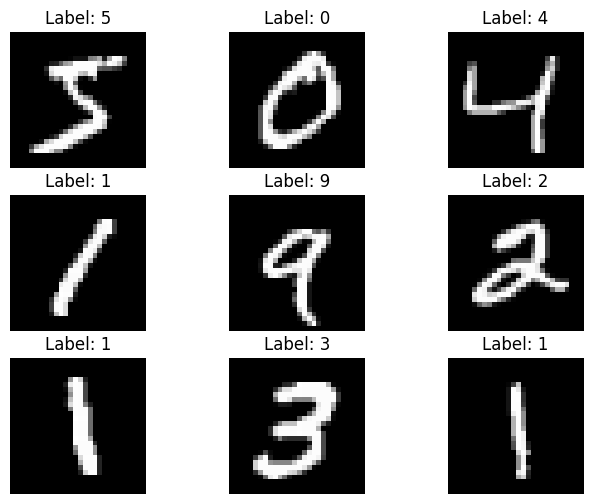

In [14]:
num_images = 9
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8, 6))
idx_offset = 0
for i in range(factor):
    index = idx_offset + i * factor
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap='gray')
        ax[i, j].set_title('Label: {0}'.format(str(y[index + j])))
        ax[i, j].set_axis_off()

In [15]:
# Splitting data

x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 0 detector

In [16]:
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

indx_0 = np.where(y_train=='0')
y_train_0[indx_0] = 1

indx_0 = np.where(y_test =='0')
y_test_0[indx_0]=1

In [17]:
num_pos = len(np.where(y_train_0==1)[0])
num_neg = len(np.where(y_train_0==-1)[0])
print(num_pos, num_neg)

5923 54077


In [18]:
base_clf = DummyClassifier(strategy='most_frequent')

In [19]:
base_clf.fit(x_train, y_train_0)
print('Training Accuracy: ', base_clf.score(x_train, y_train_0))
print('Test Accuracy: ',base_clf.score(x_test, y_test_0) )

Training Accuracy:  0.9012833333333333
Test Accuracy:  0.902


## Perceptron

In [20]:
bin_clf = Perceptron(max_iter=100, random_state=1729)

In [22]:
bin_clf.fit(x_train, y_train_0)
print("Dimension of Weights w: ", bin_clf.coef_.shape)
print('Bias: ', bin_clf.intercept_)
print('Loss function: ', bin_clf.loss_function_)

Dimension of Weights w:  (1, 784)
Bias:  [-108.]
Loss function:  <sklearn.linear_model._sgd_fast.Hinge object at 0x14f97eef0>


/Users/satviksawhney/Downloads/IITMadras/MLP (Practical)/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:102: FutureWarning: Attribute `loss_function_` was deprecated in version 1.4 and will be removed in 1.6.
  warnings.warn(msg, category=FutureWarning)


In [23]:
y_hat_train = bin_clf.predict(x_train)
print('Training Accuracy: ', bin_clf.score(x_train, y_train_0))

Training Accuracy:  0.99095


In [24]:
print('Test Accuracy: ', bin_clf.score(x_test, y_test_0))

Test Accuracy:  0.989


### Displaying Predictions

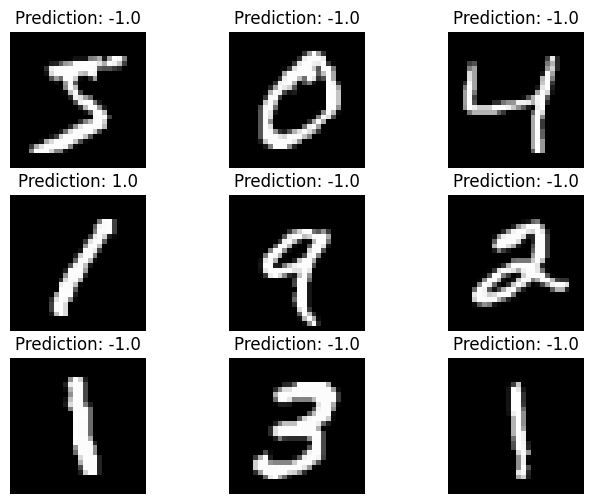

In [26]:
y_hat_test_0 = bin_clf.predict(x_test)
num_images = 9
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8, 6))
idx_offset = 0
for i in range(factor):
    index = idx_offset + i * factor
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap='gray')
        ax[i, j].set_title('Prediction: {0}'.format(str(y_hat_test_0[index + j])))
        ax[i, j].set_axis_off()

In [28]:
num_misclssified = np.count_nonzero(y_train_0==-1)
num_correctpred = len(y_train_0)-num_misclssified
accuracy = 1 - num_correctpred/len(y_train_0)
print(accuracy)

0.9012833333333333


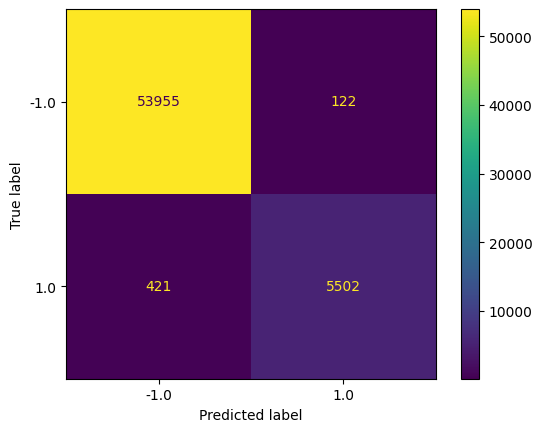

In [29]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

In [30]:
# Precision and Recall
cf_matrix = cm_display.confusion_matrix

tn = cf_matrix[0, 0]
fn = cf_matrix[1, 0]
tp = cf_matrix[1, 1]
fp = cf_matrix[0, 1]

In [31]:
precision = tp/(tp+fp)
print('Precision: ',precision)

recall = tp/(tp+fn)
print('Recall: ',recall)

accuracy = (tp+tn)/(tp+tn+fp+fn)
print('Accuracy: ',accuracy)

Precision:  0.9783072546230441
Recall:  0.9289211548201924
Accuracy:  0.99095


In [33]:
bin_clf = Perceptron(max_iter=100,
                     random_state=1729)
scores = cross_validate( bin_clf ,x_train, y_train_0, cv=5, 
                        scoring=['precision', 'recall', 'f1'], 
                        return_estimator=True )
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([0.77516699, 1.08150578, 0.72888112, 0.68262315, 0.93909788]),
 'score_time': array([0.01988292, 0.01012611, 0.01259494, 0.00923514, 0.0420053 ]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


In [34]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



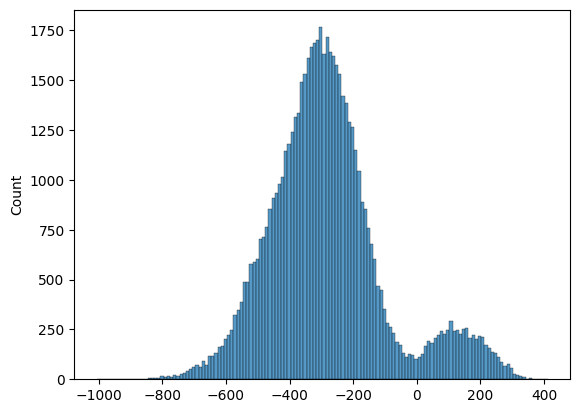

In [37]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(x_train, y_train_0)
y_scores = bin_clf.decision_function(x_train)
sns.histplot(np.sort(y_scores))
plt.show()

In [38]:
precisions , recalls , thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)

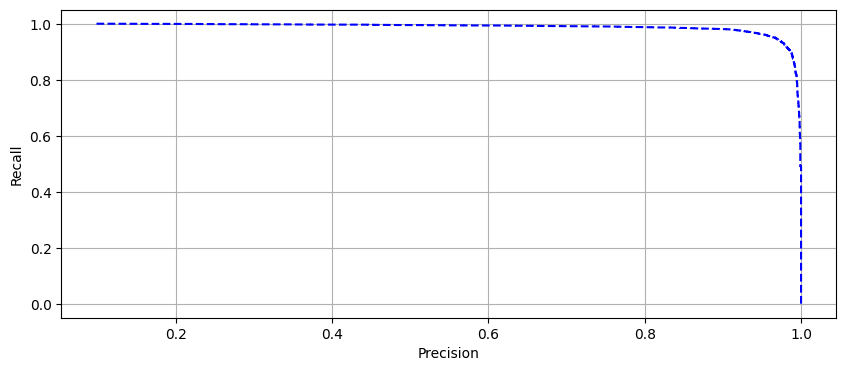

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(precisions[:-1], recalls[:-1], 'b--')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

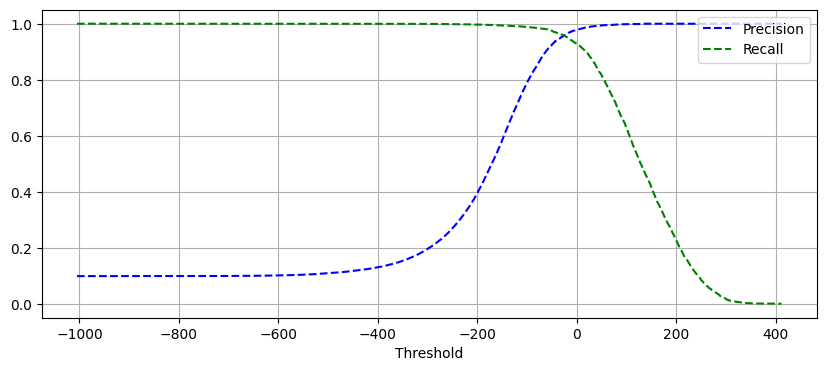

In [42]:
plt.figure(figsize=(10, 4))
plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
plt.plot(thresholds, recalls[:-1], 'g--', label="Recall")
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()